  2%|█▉                                                                            25/1000 [ETA: 44:15, Elapsed: 01:08]


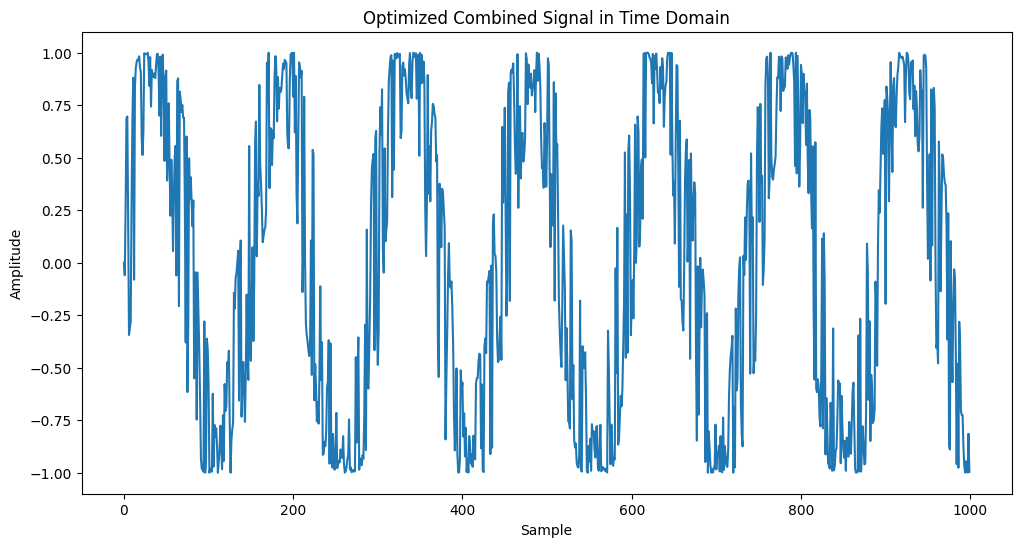

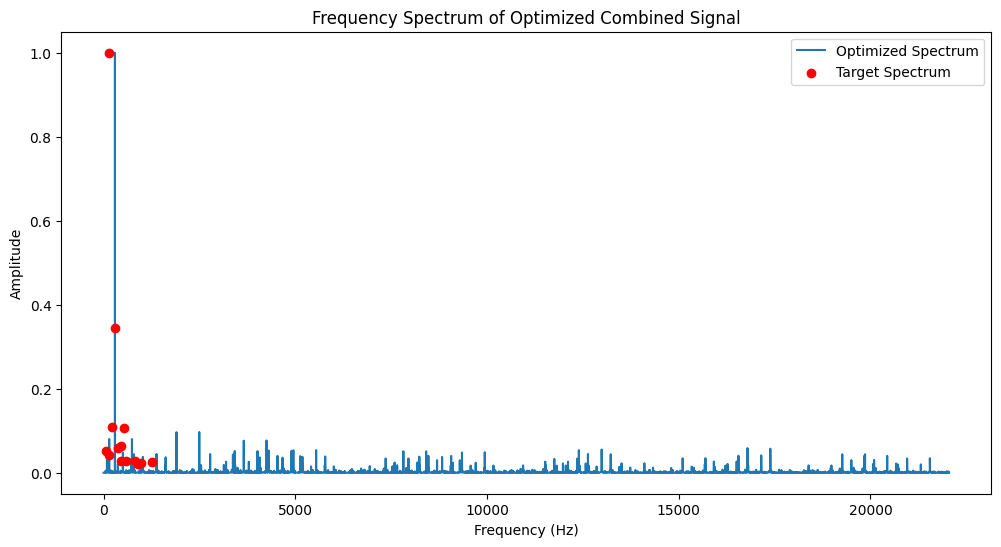

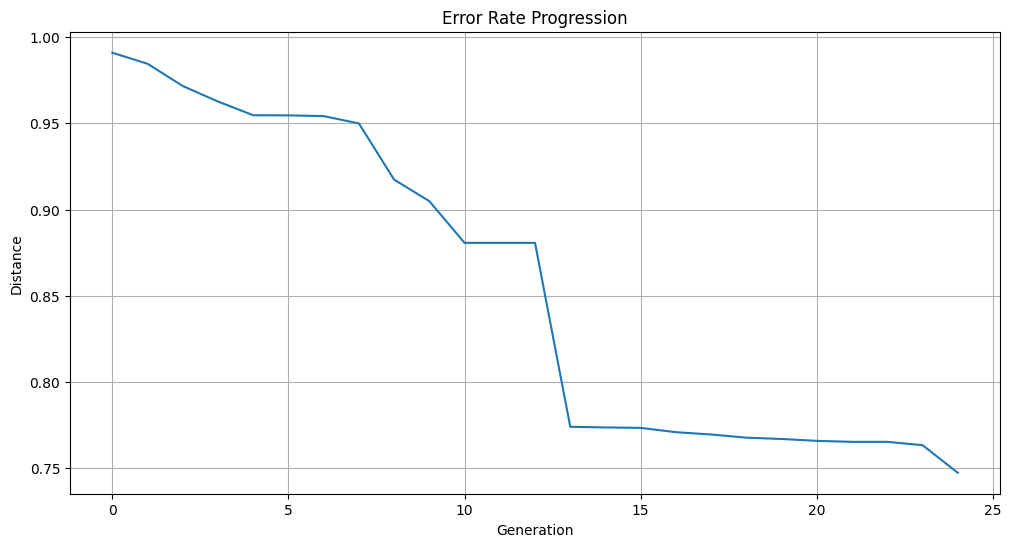

Modulator 4:

    Frequency: 4161.810181756688
    Amplitude: 1.5148999968879209

Modulator 3:

    Frequency: 3284.2798474129663
    Amplitude: 3.089859597904177

Modulator 2:

    Frequency: 2199.0067901336993
    Amplitude: 0.6383478010327891

Modulator 1:

    Frequency: 296.9865068714848
    Amplitude: 3.8755237628436188

[2024-08-28 14:20:35] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm_beta\rendered_audio\optimized_output_fm_cellotest.wav


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution, dual_annealing, basinhopping
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
import librosa
import os
from IPython.display import Audio, display
from generate_wave_file import generate_wave_file

# Load TSV file into a DataFrame
file_path = 'tsv/cello_single.tsv'
df = pd.read_csv(file_path, sep='\t')

# Extract frequencies and amplitudes
frequencies = df['Frequency (Hz)'].values
amplitudes = df['Amplitude'].values

# Normalize amplitudes
amplitudes /= np.max(amplitudes)

# Parameters
duration = 1  # seconds
sample_rate = 44100  # samples per second

# Waveform generator for sine wave
def sine_wave(frequency, amplitude, duration, sample_rate, modulator=None):
    time_vector = np.linspace(0, duration, int(sample_rate * duration))
    if modulator is not None:
        return amplitude * np.sin(2 * np.pi * frequency * time_vector + modulator)
    return amplitude * np.sin(2 * np.pi * frequency * time_vector)

# FM modulation setup
def fm_modulate(carrier_freq, carrier_amp, modulator_signal, duration, sample_rate):
    time_vector = np.linspace(0, duration, int(sample_rate * duration))
    return carrier_amp * np.sin(2 * np.pi * carrier_freq * time_vector + modulator_signal)

# Compute MFCC
def compute_mfcc(signal, sample_rate, n_mfcc=20):
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

# Global variables to store the last compared spectra
last_fft_result = None
last_target_spectrum = None

def compute_objective(params, target_freqs, target_amps, duration, sample_rate, objective_type, target_mfcc_mean=None):
    global last_fft_result, last_target_spectrum

    combined_signal = np.zeros(int(sample_rate * duration))
    
    # Unpack parameters for each oscillator
    freq4, amp4 = params[0], params[1]
    freq3, amp3 = params[2], params[3]
    freq2, amp2 = params[4], params[5]
    freq1, amp1 = params[6], params[7]

    # Generate modulator signals
    mod4 = sine_wave(freq4, amp4, duration, sample_rate)
    mod3 = fm_modulate(freq3, amp3, mod4, duration, sample_rate)
    mod2 = fm_modulate(freq2, amp2, mod3, duration, sample_rate)
    combined_signal += fm_modulate(freq1, amp1, mod2, duration, sample_rate)
    
    # Normalize combined signal
    max_val = np.max(np.abs(combined_signal))
    if max_val > 0:
        combined_signal /= max_val
    
    # Compute FFT
    fft_result = np.abs(np.fft.fft(combined_signal))
    fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)
    
    # Compute the target spectrum
    target_spectrum = np.zeros_like(fft_result)
    for target_freq, target_amp in zip(target_freqs, target_amps):
        closest_index = np.argmin(np.abs(fft_freqs - target_freq))
        target_spectrum[closest_index] = target_amp

    # Store the last spectra for access
    last_fft_result = fft_result
    last_target_spectrum = target_spectrum

    # Compute the objective value based on the specified type
    epsilon = 1e-10  # Small value to avoid log(0) and division by zero
    
    if objective_type == 'itakura_saito':
        is_distance = np.sum((target_spectrum + epsilon) / (fft_result + epsilon) - np.log((target_spectrum + epsilon) / (fft_result + epsilon)) - 1)
        return is_distance
    
    elif objective_type == 'spectral_convergence':
        spectral_convergence = np.linalg.norm(np.abs(fft_result) - np.abs(target_spectrum)) / np.linalg.norm(np.abs(target_spectrum))
        return spectral_convergence
    
    elif objective_type == 'cosine_similarity':
        cosine_sim = cosine(np.abs(fft_result), np.abs(target_spectrum))
        return cosine_sim
    
    elif objective_type == 'euclidean_distance':
        euclidean_distance = np.linalg.norm(np.abs(fft_result) - np.abs(target_spectrum))
        return euclidean_distance
    
    elif objective_type == 'manhattan_distance':
        manhattan_distance = np.sum(np.abs(np.abs(fft_result) - np.abs(target_spectrum)))
        return manhattan_distance
    
    elif objective_type == 'kullback_leibler_divergence':
        kl_divergence = np.sum(target_spectrum * np.log((target_spectrum + epsilon) / (fft_result + epsilon)))
        return kl_divergence

    elif objective_type == 'pearson_correlation_coefficient':
        pearson_corr, _ = pearsonr(np.abs(fft_result), target_spectrum)
        return 1 - pearson_corr  # We subtract from 1 because we want to minimize this objective function
    
    elif objective_type == 'mfcc_distance':
        generated_mfcc_mean = compute_mfcc(combined_signal, sample_rate)
        mfcc_distance = np.linalg.norm(generated_mfcc_mean - target_mfcc_mean)
        return mfcc_distance

# Compute target MFCC mean
target_signal = np.zeros(int(sample_rate * duration))
for freq, amp in zip(frequencies, amplitudes):
    target_signal += sine_wave(freq, amp, duration, sample_rate)
target_signal /= np.max(np.abs(target_signal))
target_mfcc_mean = compute_mfcc(target_signal, sample_rate)

# Choose objective function
objective_type = 'cosine_similarity'  # Change this to desired objective type

objective_function = lambda params, target_freqs, target_amps, duration, sample_rate: compute_objective(params, target_freqs, target_amps, duration, sample_rate, objective_type, target_mfcc_mean)

# Optimization constraints
bounds = [
    (0.01, 5000),  # Frequency bounds for osc4
    (0, 12),  # Amplitude bounds for osc4
    (0.01, 5000),  # Frequency bounds for osc3
    (0, 12),  # Amplitude bounds for osc3
    (0.01, 5000),  # Frequency bounds for osc2
    (0, 12),  # Amplitude bounds for osc2
    (1, 5000),  # Frequency bounds for osc1
    (0, 12)   # Amplitude bounds for osc1
]

# Select optimization method
optimization_method = 'dual_annealing'  # Change this to 'differential_evolution' for using differential evolution

# Initialize progress bar and error history
n_generations = 1000  # Adjusted for faster convergence
pbar = tqdm(total=n_generations, unit=' iteration', bar_format='{l_bar}{bar} {n}/{total} [ETA: {remaining}, Elapsed: {elapsed}]')
error_history = []

# Callback function to update progress bar and error history
def callback(param, convergence=None, context=None):
    error = objective_function(param, frequencies, amplitudes, duration, sample_rate)
    error_history.append(error)
    pbar.update(1)

# Run optimization
if optimization_method == 'differential_evolution':
    result = differential_evolution(objective_function, bounds, args=(frequencies, amplitudes, duration, sample_rate), 
                                    strategy='best1bin', maxiter=n_generations, popsize=10, tol=1e-6, mutation=(0.5, 1), 
                                    recombination=0.7, callback=callback, workers=1)

elif optimization_method == 'dual_annealing':
    result = dual_annealing(objective_function, bounds, args=(frequencies, amplitudes, duration, sample_rate), maxiter=n_generations, callback=lambda x, f, context: callback(x, f))

elif optimization_method == 'basinhopping':
    initial_guess = np.mean(bounds, axis=1)  # Start from the middle of each bound
    result = basinhopping(
        objective_function,
        initial_guess,
        niter=n_generations,
        minimizer_kwargs={
            'method': 'L-BFGS-B',
            'args': (frequencies, amplitudes, duration, sample_rate),
            'bounds': bounds
        },
        callback=lambda x, f, accept: callback(x, f)
    )
    
# Close progress bar
pbar.close()

# Extract optimal parameters
optimal_params = result.x
optimal_frequencies = optimal_params[0::2]
optimal_amplitudes = optimal_params[1::2]

# Generate combined signal using optimal parameters
mod4 = sine_wave(optimal_frequencies[0], optimal_amplitudes[0], duration, sample_rate)
mod3 = fm_modulate(optimal_frequencies[1], optimal_amplitudes[1], mod4, duration, sample_rate)
mod2 = fm_modulate(optimal_frequencies[2], optimal_amplitudes[2], mod3, duration, sample_rate)
combined_signal = fm_modulate(optimal_frequencies[3], optimal_amplitudes[3], mod2, duration, sample_rate)

# Normalize combined signal
max_val = np.max(np.abs(combined_signal))
if max_val > 0:
    combined_signal /= max_val

# Compute FFT for plotting
fft_result = np.fft.fft(combined_signal)
fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)
fft_result_np = np.abs(fft_result)

# Normalize the FFT result for comparison
fft_result_np /= np.max(fft_result_np)

# Time domain plot
plt.figure(figsize=(12, 6))
plt.plot(combined_signal[:1000])  # Plot the first 1000 samples
plt.title('Optimized Combined Signal in Time Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Frequency domain plot
plt.figure(figsize=(12, 6))
plt.plot(fft_freqs[:len(fft_freqs)//2], fft_result_np[:len(fft_result_np)//2], label='Optimized Spectrum')
plt.scatter(frequencies, amplitudes, color='red', label='Target Spectrum', zorder=5)
plt.title('Frequency Spectrum of Optimized Combined Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot error history
plt.figure(figsize=(12, 6))
plt.plot(error_history)
plt.title('Error Rate Progression')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

# Print optimal parameters in the specified format
for i, (freq, amp) in enumerate(zip(optimal_frequencies, optimal_amplitudes)):
    print(f"Modulator {4-i}:\n")
    print(f"    Frequency: {freq}")
    print(f"    Amplitude: {amp}\n")

# Synthesize and save the audio using the provided script
output_filename = 'optimized_output_fm_cellotest.wav'
generate_wave_file(combined_signal, sample_rate, fs_target_name='44.1kHz', custom_filename=output_filename, save_to_file=True)

output_path = os.path.join('rendered_audio', output_filename)
display(Audio(filename=output_path))


In [2]:
# Set new desired duration
new_duration = 30.0  # Set the desired duration in seconds

# Resynthesize the sound using the optimal parameters for the new duration
mod4_new = sine_wave(optimal_frequencies[0], optimal_amplitudes[0], new_duration, sample_rate)
mod3_new = fm_modulate(optimal_frequencies[1], optimal_amplitudes[1], mod4_new, new_duration, sample_rate)
mod2_new = fm_modulate(optimal_frequencies[2], optimal_amplitudes[2], mod3_new, new_duration, sample_rate)
combined_signal_new = fm_modulate(optimal_frequencies[3], optimal_amplitudes[3], mod2_new, new_duration, sample_rate)

# Normalize the resynthesized signal
max_val_new = np.max(np.abs(combined_signal_new))
if max_val_new > 0:
    combined_signal_new /= max_val_new

# Synthesize and save the new audio file
output_filename_new = 'optimized_output_fm_test.wav'
generate_wave_file(combined_signal_new, sample_rate, fs_target_name='44.1kHz', custom_filename=output_filename_new, save_to_file=True)

# Display the new audio
output_path_new = os.path.join('rendered_audio', output_filename_new)
display(Audio(filename=output_path_new))

[2024-08-28 14:20:35] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm_beta\rendered_audio\optimized_output_fm_test.wav


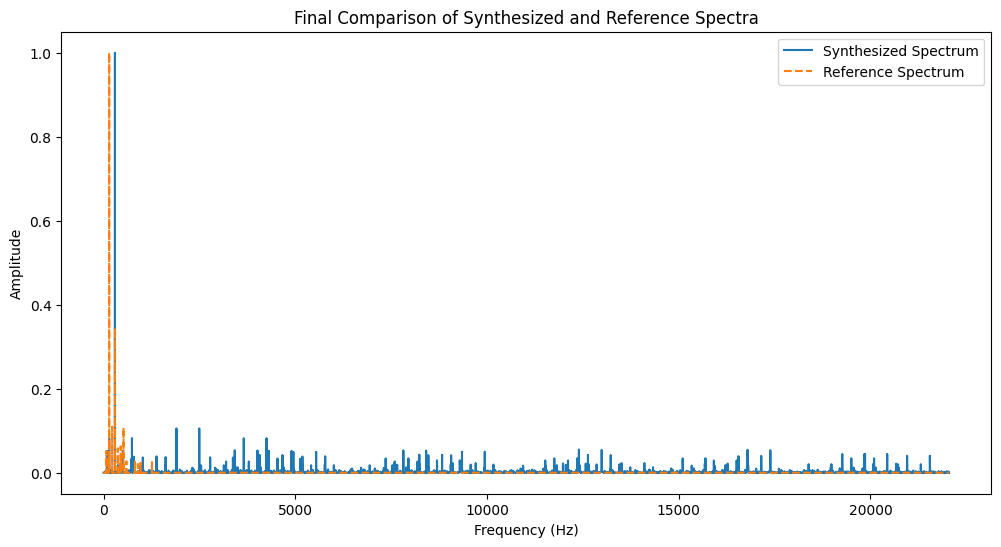

In [3]:
# After the optimization is completed
# Access the last compared spectra
final_synthesized_spectrum = last_fft_result
final_reference_spectrum = last_target_spectrum

# Normalize the final spectra for plotting
final_synthesized_spectrum /= np.max(final_synthesized_spectrum)
final_reference_spectrum /= np.max(final_reference_spectrum)

# Plot the last compared spectra
plt.figure(figsize=(12, 6))
plt.plot(fft_freqs[:len(fft_freqs)//2], final_synthesized_spectrum[:len(final_synthesized_spectrum)//2], label='Synthesized Spectrum')
plt.plot(fft_freqs[:len(fft_freqs)//2], final_reference_spectrum[:len(final_reference_spectrum)//2], label='Reference Spectrum', linestyle='--')
plt.title('Final Comparison of Synthesized and Reference Spectra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [4]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr

def mean_squared_error(target_spectrum, optimized_spectrum):
    """Calculate the Mean Squared Error (MSE) between two spectra."""
    return np.mean((target_spectrum - optimized_spectrum) ** 2)

def root_mean_squared_error(target_spectrum, optimized_spectrum):
    """Calculate the Root Mean Squared Error (RMSE) between two spectra."""
    return np.sqrt(mean_squared_error(target_spectrum, optimized_spectrum))

def mean_absolute_error(target_spectrum, optimized_spectrum):
    """Calculate the Mean Absolute Error (MAE) between two spectra."""
    return np.mean(np.abs(target_spectrum - optimized_spectrum))

def cosine_similarity(target_spectrum, optimized_spectrum):
    """Calculate the Cosine Similarity between two spectra."""
    return 1 - cosine(target_spectrum, optimized_spectrum)

def pearson_correlation(target_spectrum, optimized_spectrum):
    """Calculate the Pearson Correlation Coefficient between two spectra."""
    # Check if either spectrum is constant
    if np.all(target_spectrum == target_spectrum[0]) or np.all(optimized_spectrum == optimized_spectrum[0]):
        return np.nan  # Return NaN if correlation is not defined
    return pearsonr(target_spectrum, optimized_spectrum)[0]

def spectral_convergence(target_spectrum, optimized_spectrum):
    """Calculate the Spectral Convergence between two spectra."""
    return np.linalg.norm(optimized_spectrum - target_spectrum) / np.linalg.norm(target_spectrum)

# Extract the positive parts of the spectra
positive_freqs = fft_freqs[:len(fft_freqs)//2]
positive_synthesized_spectrum = final_synthesized_spectrum[:len(final_synthesized_spectrum)//2]
positive_reference_spectrum = final_reference_spectrum[:len(final_reference_spectrum)//2]

# Calculate fit metrics between the positive parts of the spectra
mse = mean_squared_error(positive_reference_spectrum, positive_synthesized_spectrum)
rmse = root_mean_squared_error(positive_reference_spectrum, positive_synthesized_spectrum)
mae = mean_absolute_error(positive_reference_spectrum, positive_synthesized_spectrum)
cos_sim = cosine_similarity(positive_reference_spectrum, positive_synthesized_spectrum)
pearson_corr = pearson_correlation(positive_reference_spectrum, positive_synthesized_spectrum)
spec_convergence = spectral_convergence(positive_reference_spectrum, positive_synthesized_spectrum)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Cosine Similarity: {cos_sim}")
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spectral Convergence: {spec_convergence}")

Mean Squared Error (MSE): 7.020271178990993e-05
Root Mean Squared Error (RMSE): 0.008378705854122696
Mean Absolute Error (MAE): 0.0009399369277643904
Cosine Similarity: 0.35699307545426495
Pearson Correlation Coefficient: 0.3581305551910232
Spectral Convergence: 1.1562767504440812
